<font style="font-size:1.4em" color='Grey'>Imports</font>


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from colorama import Fore, Back, Style # Nice Colors

<hr/>

<font style="font-size:3.5em" color='#FFEECF'>Misc. Functions</font>

<font style="font-size:2em" color='#D16C4B'>1: Load Image <b>Thresholded</b> </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgPath </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Thresholded Image </font>


In [17]:
def loadImageT(imgPath):
    img = cv2.imread(imgPath) # 0 Because : We only need 1 color channel(?)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    return thresh

<font style="font-size:2em" color='#D16C4B'>2: Remove QZ </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : IMG With QZ Removed </font>


In [18]:
def removeQZ(img):
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]
    return qr_no_quiet_zone

<hr/>

<font style="font-size:2.5em" color='#FFEECF'>Misc. Functions <b>For Visualization Only</b></font>

<font style="font-size:1.3em" color='Grey'>To Draw : 
<ol> 
<li>Load RGB Image</li>
<li>Get Contours</li>
<li>Draw Contours</li>

</font>

<font style="font-size:2em" color='#D16C4B'>4: Load Image <b>RGB</b> </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgPath </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Image with 3 Color Channels</font>


In [19]:
def loadImageRGB(imgPath):
    img = cv2.imread(imgPath) 
    return img

<font style="font-size:2em" color='#D16C4B'>5: Get Contours </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img(Thresholded) </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Image's Contours </font>


In [20]:
def getContours(img):
    contours,heirarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours

<font style="font-size:2em" color='#D16C4B'>6: Detect Position Patterns </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgPath </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : Detected Position Patterns [ Contours ] </font>

In [21]:
def DetectPositionPattern(imgT):

    img_width  = 1012
    img_height = 1012

    contours,heirarchy = cv2.findContours(imgT,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    potential_boxes = ([])
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - 1) > 0.2: # Aspect ratio should be close to 1 if it is a square-like or rectangular shape
            continue # Not what we are looking for.
        min_size = min(w, h)
        if min_size < 0.1 * img_width:  # Img_width [Should] be the same for all images.          
            continue                    
                                        # If the Rectangle is TOO small -> It is not the locator box.
                                        # Probably doesn't need to be a % of the image. ( Could just use some number )

        center_x, center_y = (x + x + w) // 2, (y + y + h) // 2
        image_center_x, image_center_y = img_width // 2, img_height // 2

        # Check for top-left, top-right, or bottom-left corner based on relative position
        is_top_left = center_x < image_center_x * 0.4 and center_y < image_center_y * 0.4
        is_top_right = center_x > image_center_x * 1.6 and center_y < image_center_y * 0.4
        is_bottom_left = center_x < image_center_x * 0.4 and center_y > image_center_y * 1.6


        if not (is_top_left or is_top_right or is_bottom_left): # Wrong Place.
            continue

        # Potential locator box based on heuristics
        potential_boxes.append(contour)
    return potential_boxes

<font style="font-size:2em" color='#D16C4B'>7: Draw Contours </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : imgRGB,contours </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : An Image With Contours Drawn </font>

In [22]:
def drawContours(imgRGB,contours):
    for i in range(len(contours)):
        cv2.drawContours(imgRGB,contours,i,(0,255,0),4)
        i = i + 1
    plt.imshow(imgRGB,cmap='gray')

<hr/>

In [23]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,0.015*peri,True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

In [24]:
def findBorders(contours):
        # Initialize variables
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    top_right_y = float('inf')  # Track topmost Y for rightmost contender

    for cnt in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(cnt)

        # Update minimum for top-left and bottom-left
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_y = max(max_y, y + h)  # Bottom-left Y is y + height

        # Update maximum for top-right and bottom-right
        rightmost_x = x + w
        if rightmost_x > max_x:
            max_x = rightmost_x
            top_right_y = min(top_right_y, y)  # Update top-right Y if higher
        bottom_right_x = x + w
        bottom_right_y = y + h
        max_x = max(max_x, bottom_right_x)
        max_y = max(max_y, bottom_right_y)

        # Top-left corner
        top_left = (min_x, min_y)

        # Top-right corner (considering both X and Y position)
        top_right = (max_x, top_right_y)

        # Bottom-right corner
        bottom_right = (max_x, max_y)

        # Bottom-left corner
        bottom_left = (min_x, max_y)

    # Use top_left, top_right, bottom_right, and bottom_left for further processing
    print("Top-left:", top_left)
    print("Top-right:", top_right)
    print("Bottom-right:", bottom_right)
    print("Bottom-left:", bottom_left)

    return top_left, top_right, bottom_left, bottom_right

<font style="font-size:5em" color='#BD1E1E'>CHECKING FUNCTIONS -- <b>IMAGE PREPROCESSING </font>

<font style="font-size:2em" color='#D16C4B'>Is Image Skewed? </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img path </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False </font>

In [25]:
def isSkewed(imgpath):
    image = cv2.imread(imgpath)
    imageT = loadImageT(imgpath)

    cnts = getContours(imageT)

    filteredCNTS = DetectPositionPattern(imageT)

    minTheta = 0

    for cnt in filteredCNTS:
        (x,y),(width,height),theta = cv2.minAreaRect(cnt)
        theta = theta - 90
        if(theta <= minTheta):
            minTheta = theta
    if (minTheta <= -5 and minTheta != -90):
        return True # This Needs To Be Unskewed
    return False

<font style="font-size:2em" color='#D16C4B'>Final Check -- Locator Boxes </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img path </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : True Or False </font>

In [26]:
def isValid(imgPath):
    imgT = loadImageT(imgPath)
    contours = getContours(imgT)
    img_width  = 1012
    img_height = 1012
    potential_boxes = ([])
    total_boxes = ([])
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if abs(aspect_ratio - 1) > 0.2: # Aspect ratio should be close to 1 if it is a square-like or rectangular shape
            continue # Not what we are looking for.
        min_size = min(w, h)
        if min_size < 0.1 * img_width:  # Img_width [Should] be the same for all images.          
            continue                    
                                        # If the Rectangle is TOO small -> It is not the locator box.
                                        # Probably doesn't need to be a % of the image. ( Could just use some number )

        center_x, center_y = (x + x + w) // 2, (y + y + h) // 2
        image_center_x, image_center_y = img_width // 2, img_height // 2

        # Check for top-left, top-right, or bottom-left corner based on relative position
        is_top_left = center_x < image_center_x * 0.4 and center_y < image_center_y * 0.4
        is_top_right = center_x > image_center_x * 1.6 and center_y < image_center_y * 0.4
        is_bottom_left = center_x < image_center_x * 0.4 and center_y > image_center_y * 1.6


        if not (is_top_left or is_top_right or is_bottom_left): # Wrong Place.
            total_boxes.append(contour)
            continue

        # Potential locator box based on heuristics
        potential_boxes.append(contour)

    if len(potential_boxes) == 9:
        print(Fore.GREEN + 'Passed!')
        return (True,0)
    elif(len(potential_boxes) != len(total_boxes) == 9):
        print(Fore.Orange + 'Boxes are there but placed incorrectly...')
        return (False,1)            # 1 == All Boxes are there but placed incorrectly
    else:
        print(Fore.RED + 'Failed.')
        print(Fore.YELLOW + 'Potential Boxes Found : '+ str(len(potential_boxes)))
        return (False,2)            # 2 == Not All Boxes are There

<hr/>

<font style="font-size:5em" color='#00FFFF'>APPLYING FUNCTIONS -- <b>IMAGE PROCESSING </font>

<font style="font-size:2em" color='#D16C4B'>Rotate Image <b> 90 Degrees</font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img path </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : rotated_Img </font>

In [27]:
def rotateImg(img_path):
    img = cv2.imread(img_path)
    return cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)

<font style="font-size:2em" color='#D16C4B'>Invert Colors </font>

<font style="font-size:1.2em" color='#C4FCF1'>Parameters : img path </font>

<font style="font-size:1.2em" color='#82AFFF'>Returns : rotated_Img </font>

In [28]:
def invertImg(img_path):
    img = cv2.imread(img_path)
    return cv2.bitwise_not(img) # Or 255 - img

<hr/>

<h1>Playground</h1>

Failed.
Potential Boxes Found : 8


1012

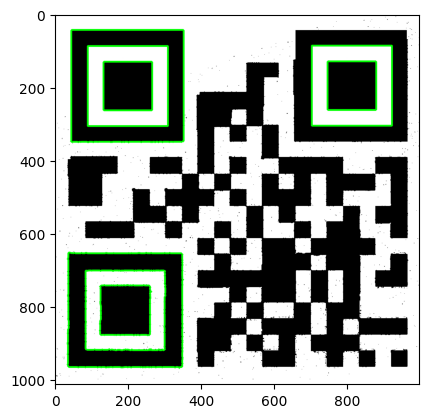

In [34]:
img1  = 'TC/01.png'
img2  = 'TC/02.png'
img3  = 'TC/03.png'
img4  = 'TC/04.png'
img5  = 'TC/05.png'
img6  = 'TC/06.png'
img7  = 'TC/07.png'
img8  = 'TC/08.png'
img9  = 'TC/09.png'
img10 = 'TC/10.png'
img11 = 'TC/11.png'
img12 = 'TC/12.png'
img13 = 'TC/13.png'
img14 = 'TC/14.png'

imgPaths = [img1, img2, img3, img4, img5, img6, img7,img8,img9,img10,img11,img12,img13,img14]

isValid('TC/07 - Copy.png')

imgT = loadImageT('TC/07 - Copy.png')
img = loadImageRGB('TC/07 - Copy.png')

cnt = DetectPositionPattern(imgT)

drawContours(img,cnt)

img.shape[0]

<h2>Warping</h2>

In [30]:
img = cv2.imread('TC/06.png')


topleft = (316,197)
topright = (974,93)
bottomleft=(60,953)
bottomright=(719,847)

width,height = 1012,1012


pts1 = np.float32([[300,197],[974,93],[60,953],[719,847]])
pts2 = np.float32([[0,0],[0,width],[height,0],[width,height]])



matrix = cv2.getPerspectiveTransform(pts1,pts2)
output1 = cv2.warpPerspective(img,matrix,(width,height))
output = cv2.cvtColor(output1,cv2.COLOR_BGR2GRAY)

contours = getContours(output)

filterContours(contours)

NameError: name 'filterContours' is not defined

<h2>Rotating</h2>

In [ ]:
image = cv2.imread('TC/02.png')
imageT = loadImageT('TC/02.png')

cnts = getContours(imageT)

filteredCNTS = DetectPositionPattern(imageT)

minTheta = 0

(h, w) = image.shape[:2]

center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, minTheta, 1.0)
rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)





filename = 'newimage.png'
cv2.imwrite(filename,rotated)

newimg = loadImageT('TC/newimage.png')


-8.259429931640625
emad
-8.259429931640625
emad


<h2>Checking Stuff</h2>

Size before QZ Removal:  (1012, 1012, 3)
Size after QZ Removal:  (924, 924)


88

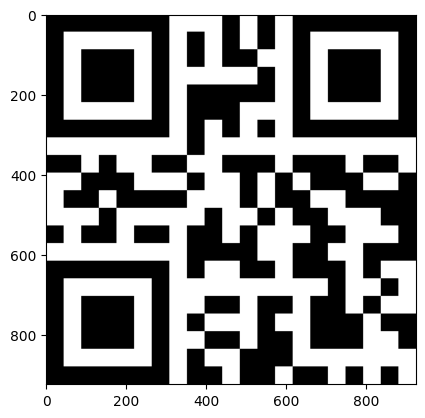

In [ ]:
img = cv2.imread('TC/01.png')
imgT = loadImageT('TC/01.png')

r1 = img.shape

print('Size before QZ Removal: ',r1)

img = removeQZ(imgT)

plt.imshow(img,cmap='gray')

r2 = img.shape
print('Size after QZ Removal: ',r2)

r1[0] - r2[0] # The amount of white space surrounding the QR Codes in 88 * 88